In [9]:
import pandas as pd           
import numpy as np              
import matplotlib.pyplot as plt  
import seaborn as sns            
import os                        
import cv2                      
from PIL import Image            
from itertools import chain 

In [15]:
import pandas as pd
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras import layers, regularizers, Model
from tensorflow.keras.optimizers import Adamax, SGD           
from tensorflow.keras.regularizers import l2               
from tensorflow.keras.utils import to_categorical, plot_model   
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory  
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [17]:
H, W = 224, 224
IMG_SIZE = (H, W)                  
IMG_SHAPE = (H, W, 3)
BATCH_SIZE = 32                        
EPOCHS = 10                          
LEARNING_RATE = 0.0001                
CLASS_NAMES = ['NORMAL', 'PNEUMONIA']  
CLASS_COUNT = len(CLASS_NAMES)

In [20]:
import os
import pandas as pd


base_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/" 


splits = ["test", "train", "val"]
labels = ["NORMAL", "PNEUMONIA"]

file_paths = []
file_labels = []

for split in splits:
    split_dir = os.path.join(base_dir, split)

    
    # Loop through each label (normal, pneumonia)
    for label in labels:
        label_dir = os.path.join(split_dir, label)
        
        
        if os.path.exists(label_dir):
    
            for file_name in os.listdir(label_dir):
                
                if os.path.isfile(os.path.join(label_dir, file_name)):
                    
                    file_paths.append(os.path.join(label_dir, file_name))
                    file_labels.append(label)


In [ ]:
df = pd.DataFrame({
    "name": file_paths,
    "label": file_labels
})


df.to_csv("pneumonia_dataset.csv", index=False)
print("DataFrame saved as 'pneumonia_dataset.csv'")
print(df.head())
print(df.tail())

DataFrame saved as 'pneumonia_dataset.csv'
                                                name   label
0  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL
1  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL
2  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL
3  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL
4  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL
                                                   name      label
5851  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
5852  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
5853  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
5854  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
5855  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split


# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# First split: 70% train, 30% remaining


train_df, temp_df = train_test_split(
    df,
    test_size=0.35,  # 30% for valid + test
    stratify=df["label"],  
    random_state=42
)
valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.4,  # 10/30 = 1/3 for test
    stratify=temp_df["label"],
    random_state=42
)
print(f"Train set: {len(train_df)} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set: {len(valid_df)} samples ({len(valid_df)/len(df)*100:.1f}%)")
print(f"Test set: {len(test_df)} samples ({len(test_df)/len(df)*100:.1f}%)")
print(f"Total: {len(train_df) + len(valid_df) + len(test_df)} samples")




Train set: 3806 samples (65.0%)
Validation set: 1230 samples (21.0%)
Test set: 820 samples (14.0%)
Total: 5856 samples


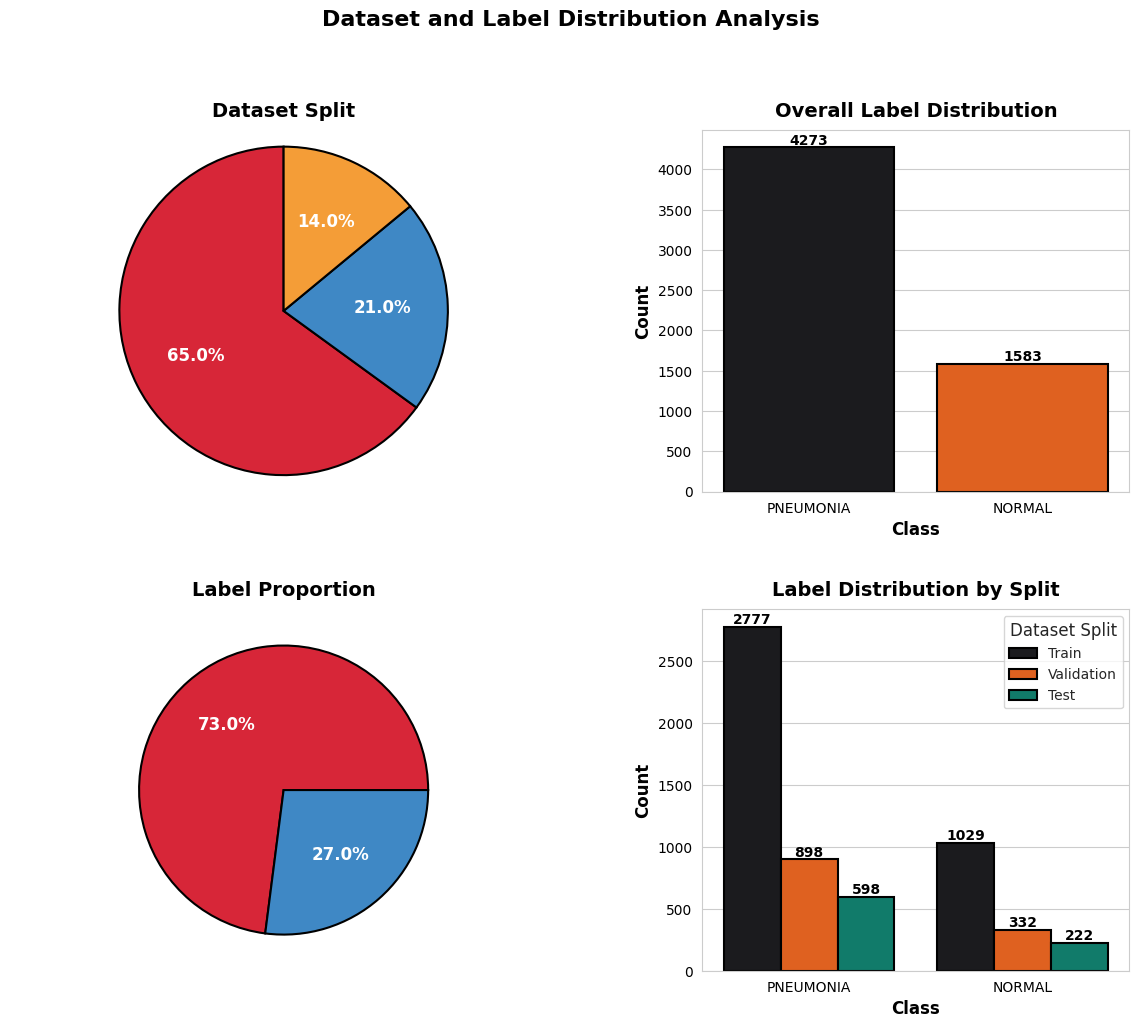

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


pie_colors = ["#D72638", "#3F88C5", "#F49D37"]  
bar_colors = ["#1B1B1E", "#FF5700", "#008C76"]  

plt.figure(figsize=(12, 10), dpi=100)

# 1. Pie Chart
plt.subplot(2, 2, 1)
sizes = [len(train_df), len(valid_df), len(test_df)]
labels = ['Training Set', 'Validation Set', 'Test Set']
plt.pie(sizes, labels=labels, autopct=lambda pct: f'{pct:.1f}%', startangle=90, 
        colors=pie_colors, textprops={'fontsize': 12, 'fontweight': 'bold', 'color': 'white'}, 
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
plt.title('Dataset Split', fontsize=14, fontweight='bold', pad=10, color="black")
plt.axis('equal') 

# 2. Bar Plot
plt.subplot(2, 2, 2)
ax2 = sns.countplot(x="label", data=df, palette=bar_colors, edgecolor='black', linewidth=1.5)

for p in ax2.patches:
    height = p.get_height()
    if height > 0:
        ax2.text(
            p.get_x() + p.get_width() / 2., 
            height + 0.5, 
            f'{int(height)}', 
            ha='center', 
            va='bottom', 
            fontsize=10, 
            fontweight='bold', 
            color="black"
        )

plt.title("Overall Label Distribution", fontsize=14, fontweight='bold', pad=10, color="black")
plt.xlabel("Class", fontsize=12, fontweight='bold', color="black")
plt.ylabel("Count", fontsize=12, fontweight='bold', color="black")
plt.xticks(fontsize=10, color="black")
plt.yticks(fontsize=10, color="black")

# 3. Pie Chart
plt.subplot(2, 2, 3)
df["label"].value_counts(normalize=True).plot(
    kind="pie", autopct="%1.1f%%", textprops={'fontsize': 12, 'fontweight': 'bold', 'color': 'white'}, 
    colors=pie_colors, wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
plt.title("Label Proportion", fontsize=14, fontweight='bold', pad=10, color="black")
plt.ylabel("") 

# 4. Grouped Bar Plot
plt.subplot(2, 2, 4)
combined_df = pd.concat([
    train_df.assign(split="Train"),
    valid_df.assign(split="Validation"),
    test_df.assign(split="Test")
])

# Create the grouped bar plot
ax = sns.countplot(x="label", hue="split", data=combined_df, palette=bar_colors, edgecolor='black', linewidth=1.5)

for p in ax.patches:
    height = p.get_height()
    if height > 0:  
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 0.5,                   
            f'{int(height)}',                 
            ha='center',                    
            va='bottom',                      
            fontsize=10, 
            fontweight='bold', 
            color="black"
								)
plt.title("Label Distribution by Split", fontsize=14, fontweight='bold', pad=10, color="black")
plt.xlabel("Class", fontsize=12, fontweight='bold', color="black")
plt.ylabel("Count", fontsize=12, fontweight='bold', color="black")
plt.xticks(fontsize=10, color="black")
plt.yticks(fontsize=10, color="black")
plt.legend(title="Dataset Split", title_fontsize=12, fontsize=10, loc='best')

plt.tight_layout(pad=3.0)
plt.suptitle("Dataset and Label Distribution Analysis", fontsize=16, fontweight='bold', y=1.05, color="black")


plt.show()


In [58]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size
print(f"Test data length: {ts_length}, Test batch size: {test_batch_size}, Test steps: {test_steps}")


# Data generators
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(
    train_df, x_col='name', y_col='label', target_size=IMG_SIZE,
    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=BATCH_SIZE
)
valid_gen = ts_gen.flow_from_dataframe(
    valid_df, x_col='name', y_col='label', target_size=IMG_SIZE,
     class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=BATCH_SIZE
)
test_gen = ts_gen.flow_from_dataframe(
    test_df, x_col='name', y_col='label', target_size=IMG_SIZE,
    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size
)
print("Class indices:", train_gen.class_indices)

Test data length: 820, Test batch size: 41, Test steps: 20
Found 3806 validated image filenames belonging to 2 classes.
Found 1230 validated image filenames belonging to 2 classes.
Found 820 validated image filenames belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


In [59]:
 #Get a single sample
sample_row = df[df["label"] == label].iloc[0]
img_path = sample_row["name"]

# Before generator: Load raw image
raw_img = Image.open(img_path)
if raw_img.mode != 'RGB':
    raw_img = raw_img.convert('RGB')
raw_img = raw_img.resize(IMG_SIZE, Image.Resampling.LANCZOS)  # Match generator size
raw_array = np.array(raw_img)
print(f"Before Generator (Raw Pixels, Shape: {raw_array.shape}):")
print(raw_array[0, :5, :])  # Print first


#--------------------------------------------------------------------------------------------------------------#
image_batch, label_batch = next(train_gen)

# Print pixel values after generator
print(f"After Generator (Processed Pixels, Shape: {image_batch.shape}):")
print(image_batch[0, 0, :5])

Before Generator (Raw Pixels, Shape: (224, 224, 3)):
[[ 6  6  6]
 [ 9  9  9]
 [24 24 24]
 [31 31 31]
 [35 35 35]]
After Generator (Processed Pixels, Shape: (32, 224, 224, 3)):
[[22. 22. 22.]
 [18. 18. 18.]
 [24. 24. 24.]
 [24. 24. 24.]
 [26. 26. 26.]]


/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 128293 (\N{FIRE}) mi

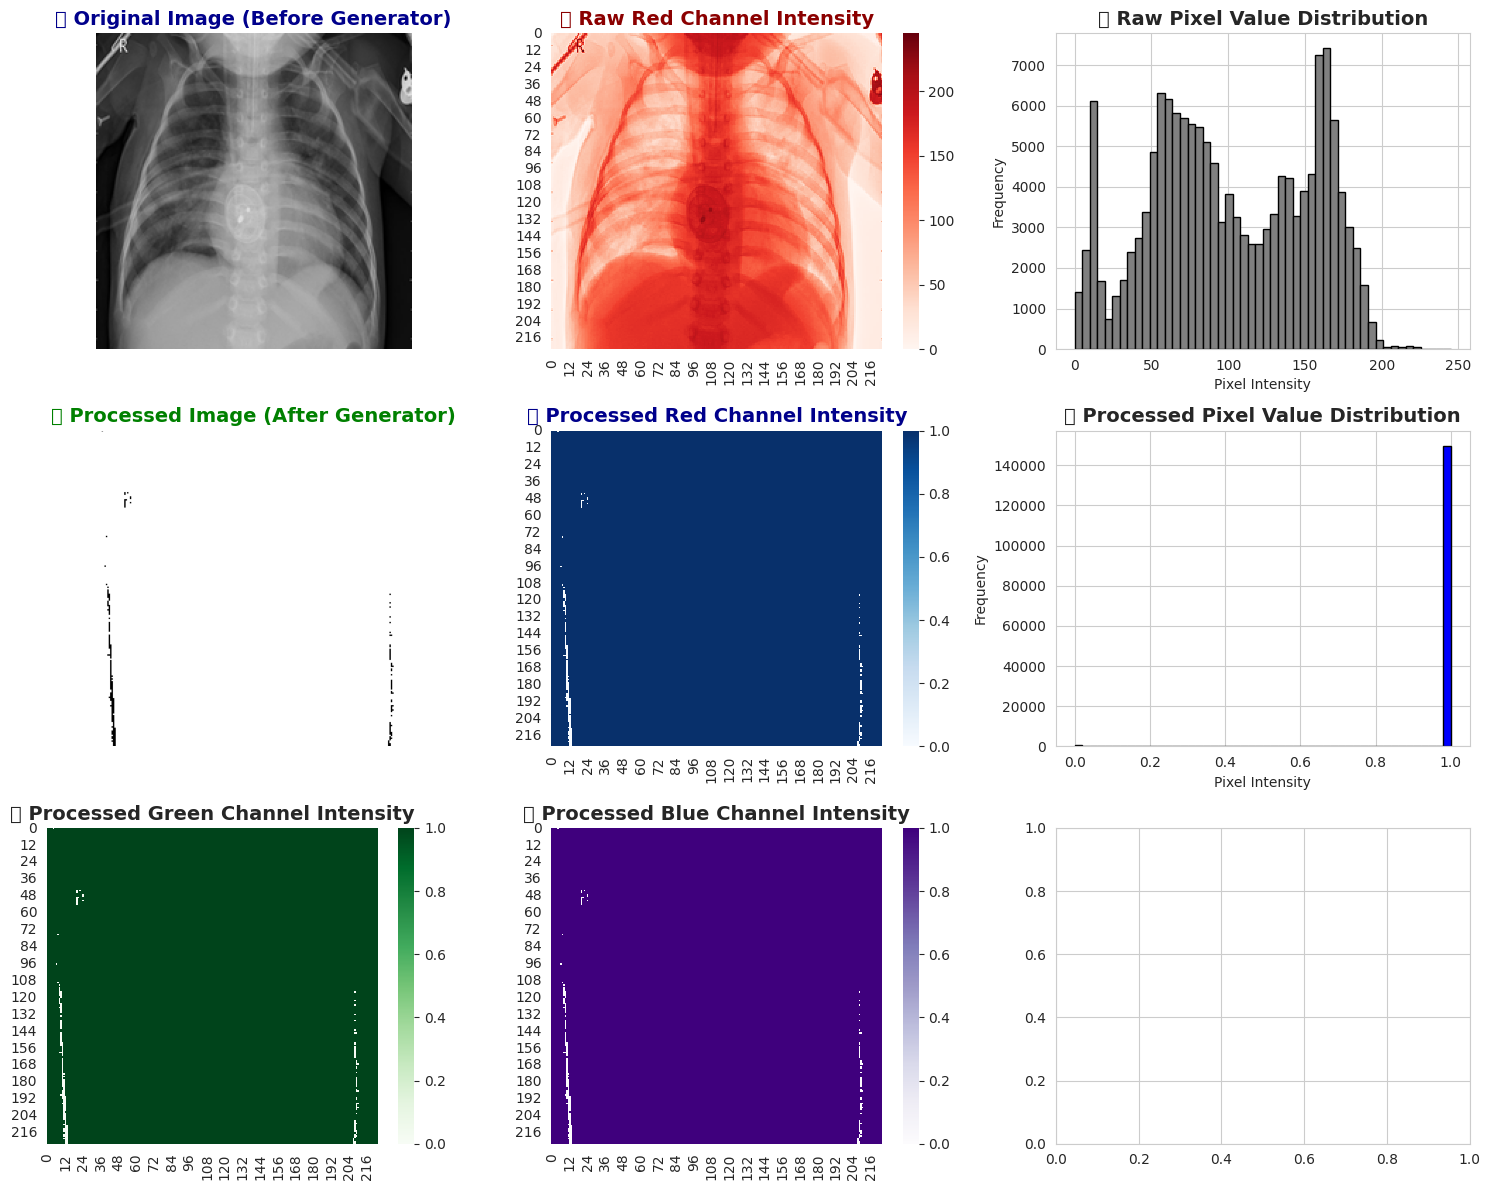

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image


sample_row = df[df["label"] == label].iloc[0]
img_path = sample_row["name"]

# Load raw image before generator processing
raw_img = Image.open(img_path)
if raw_img.mode != 'RGB':
    raw_img = raw_img.convert('RGB')

raw_img = raw_img.resize(IMG_SIZE, Image.Resampling.LANCZOS)
raw_array = np.array(raw_img)


image_batch, label_batch = next(train_gen)
processed_img = image_batch[0]  
processed_img = np.clip(processed_img, 0, 1)  


fig, axes = plt.subplots(3, 3, figsize=(15, 12))


axes[0, 0].imshow(raw_img)
axes[0, 0].set_title(" Original Image (Before Generator)", fontsize=14, fontweight='bold', color='darkblue')
axes[0, 0].axis("off")

sns.heatmap(raw_array[:, :, 0], cmap="Reds", ax=axes[0, 1], cbar=True)
axes[0, 1].set_title(" Raw Red Channel Intensity", fontsize=14, fontweight='bold', color='darkred')


axes[0, 2].hist(raw_array.flatten(), bins=50, color='gray', edgecolor='black')
axes[0, 2].set_title("📊 Raw Pixel Value Distribution", fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel("Pixel Intensity")
axes[0, 2].set_ylabel("Frequency")


axes[1, 0].imshow(processed_img)
axes[1, 0].set_title(" Processed Image (After Generator)", fontsize=14, fontweight='bold', color='green')
axes[1, 0].axis("off")


sns.heatmap(processed_img[:, :, 0], cmap="Blues", ax=axes[1, 1], cbar=True)
axes[1, 1].set_title("Processed Red Channel Intensity", fontsize=14, fontweight='bold', color='darkblue')


axes[1, 2].hist(processed_img.flatten(), bins=50, color='blue', edgecolor='black')
axes[1, 2].set_title(" Processed Pixel Value Distribution", fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel("Pixel Intensity")
axes[1, 2].set_ylabel("Frequency")


sns.heatmap(processed_img[:, :, 1], cmap="Greens", ax=axes[2, 0], cbar=True)
axes[2, 0].set_title(" Processed Green Channel Intensity", fontsize=14, fontweight='bold')


sns.heatmap(processed_img[:, :, 2], cmap="Purples", ax=axes[2, 1], cbar=True)
axes[2, 1].set_title(" Processed Blue Channel Intensity", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()



✅ Normal Samples:


<ipython-input-69-25a7483b3545>:50: UserWarning: Glyph 129729 (\N{LUNGS}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129729 (\N{LUNGS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


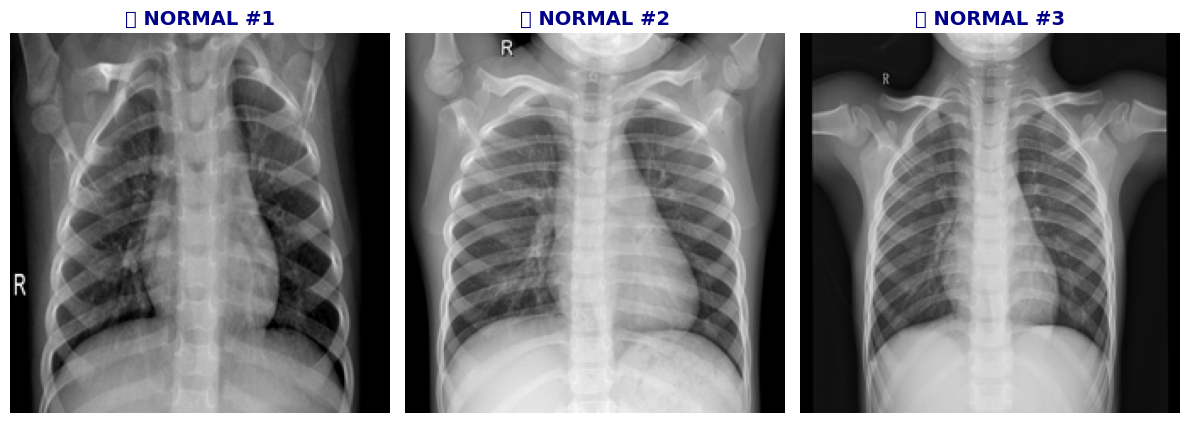


⚠️ Pneumonia Samples:


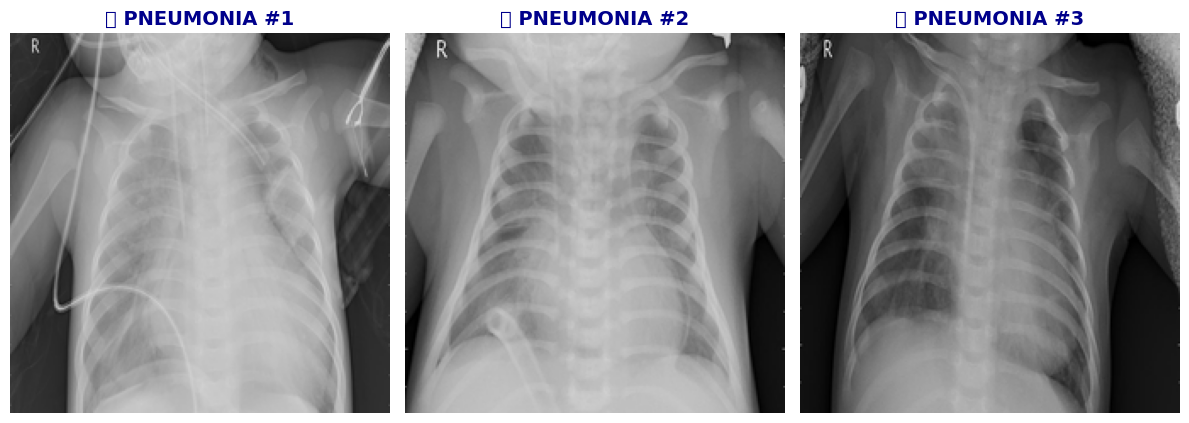

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

def plot_sample_images(df, label, num_samples=3, fixed_size=(224, 224)):
    
    
        plt.title(f"🫁 {label} #{i + 1}", fontsize=14, fontweight="bold", color="darkblue")
        plt.axis("off")


        plt.gca().spines['top'].set_color("black")
        plt.gca().spines['bottom'].set_color("black")
        plt.gca().spines['left'].set_color("black")
        plt.gca().spines['right'].set_color("black")
        plt.gca().spines['top'].set_linewidth(3)
        plt.gca().spines['bottom'].set_linewidth(3)
        plt.gca().spines['left'].set_linewidth(3)
        plt.gca().spines['right'].set_linewidth(3)
    
    plt.tight_layout()
    plt.show()

print("\n✅ Normal Samples:")
plot_sample_images(train_df, "NORMAL")

print("\n⚠️ Pneumonia Samples:")
plot_sample_images(train_df, "PNEUMONIA")


In [82]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [83]:

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Image augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1.0/255,  
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  
)

# Load train and validation data
train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="name",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

valid_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="name",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)


Found 3045 validated image filenames belonging to 2 classes.
Found 761 validated image filenames belonging to 2 classes.


In [84]:

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_gen.class_indices), activation='softmax')  # Output layer
])

# Compile 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [85]:

history = model.fit(train_gen, validation_data=valid_gen, epochs=10)


model.save("cnn_model.h5")


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 69s 673ms/step - accuracy: 0.6716 - loss: 0.6748 - val_accuracy: 0.8173 - val_loss: 0.3855
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 533ms/step - accuracy: 0.7716 - loss: 0.4434 - val_accuracy: 0.8397 - val_loss: 0.3524
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 55s 556ms/step - accuracy: 0.8132 - loss: 0.3999 - val_accuracy: 0.8765 - val_loss: 0.2965
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 528ms/step - accuracy: 0.8528 - loss: 0.3404 - val_accuracy: 0.8739 - val_loss: 0.2762
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 530ms/step - accuracy: 0.8597 - loss: 0.3272 - val_accuracy: 0.8752 - val_loss: 0.2883
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 532ms/step - accuracy: 0.8591 - loss: 0.3179 - val_accuracy: 0.8515 - val_loss: 0.3333
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 528ms/step - accuracy: 0.8569 - loss: 0.3204 - val_accuracy: 0.8962 - val_loss: 0.2286
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 55s 553ms/step - accuracy: 0.8700 - loss: 0.3047 - val_accuracy: 0.892

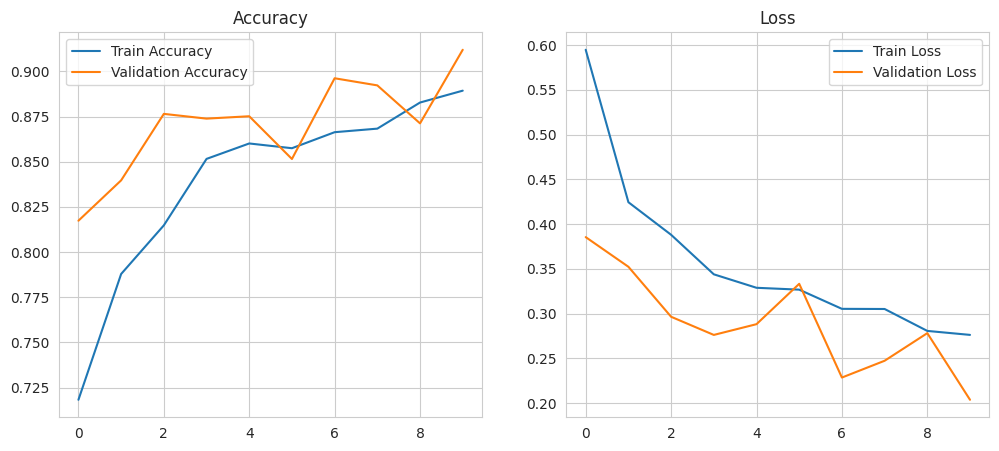

In [87]:

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [88]:
# Define constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 64  # increase the batch size for getting max accuracy


datagen = ImageDataGenerator(
    rescale=1.0/255,  
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  
)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="name",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

valid_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="name",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)


Found 3045 validated image filenames belonging to 2 classes.
Found 761 validated image filenames belonging to 2 classes.


In [93]:

model2 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_gen.class_indices), activation='softmax')  # Output layer
])


model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model2.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [96]:
# Train CNN
history2 = model2.fit(train_gen, validation_data=valid_gen, epochs=20)

# Save Model
model2.save("cnn_model.h6")


Epoch 1/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.7005 - loss: 0.6147 - val_accuracy: 0.8265 - val_loss: 0.3600
Epoch 2/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8072 - loss: 0.4151 - val_accuracy: 0.8725 - val_loss: 0.3005
Epoch 3/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8385 - loss: 0.3625 - val_accuracy: 0.8752 - val_loss: 0.3057
Epoch 4/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8363 - loss: 0.3491 - val_accuracy: 0.8712 - val_loss: 0.2898
Epoch 5/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8661 - loss: 0.3073 - val_accuracy: 0.9001 - val_loss: 0.2481
Epoch 6/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8735 - loss: 0.3085 - val_accuracy: 0.9014 - val_loss: 0.2646
Epoch 7/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8780 - loss: 0.3125 - val_accuracy: 0.9093 - val_loss: 0.2301
Epoch 8/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8624 - loss: 0.3031 - val_accuracy: 0.9120 - val_loss:

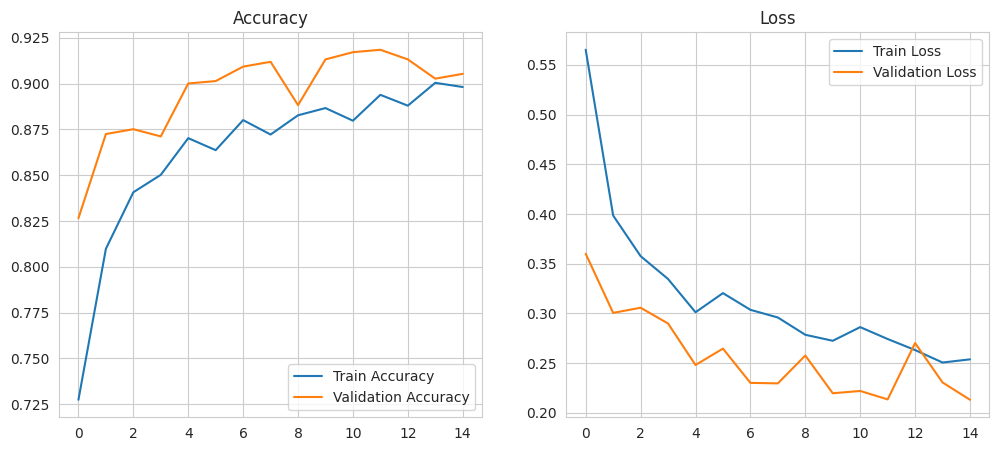

In [99]:

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [100]:



IMG_SIZE = (128, 128)
BATCH_SIZE = 128


datagen = ImageDataGenerator(
    rescale=1.0/255,  
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 
)

# Load train and validation data
train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="name",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

valid_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="name",
     y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)


Found 3045 validated image filenames belonging to 2 classes.
Found 761 validated image filenames belonging to 2 classes.


In [101]:
model3 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_gen.class_indices), activation='softmax')  # Output layer
])

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model3.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [103]:
# Train CNN
history3 = model3.fit(train_gen, validation_data=valid_gen, epochs=25)




Epoch 1/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.9182 - loss: 0.2153 - val_accuracy: 0.9106 - val_loss: 0.2068
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9163 - loss: 0.2144 - val_accuracy: 0.8817 - val_loss: 0.2666
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8863 - loss: 0.2691 - val_accuracy: 0.9001 - val_loss: 0.2255
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9197 - loss: 0.2261 - val_accuracy: 0.9146 - val_loss: 0.1971
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.9135 - loss: 0.2175 - val_accuracy: 0.9409 - val_loss: 0.1714
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.9159 - loss: 0.2154 - val_accuracy: 0.9251 - val_loss: 0.1658
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.9147 - loss: 0.2176 - val_accuracy: 0.9120 - val_loss: 0.2082
Epoch 8/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.9278 - loss: 0.1933 - val_accuracy: 0.9356 - val_loss:

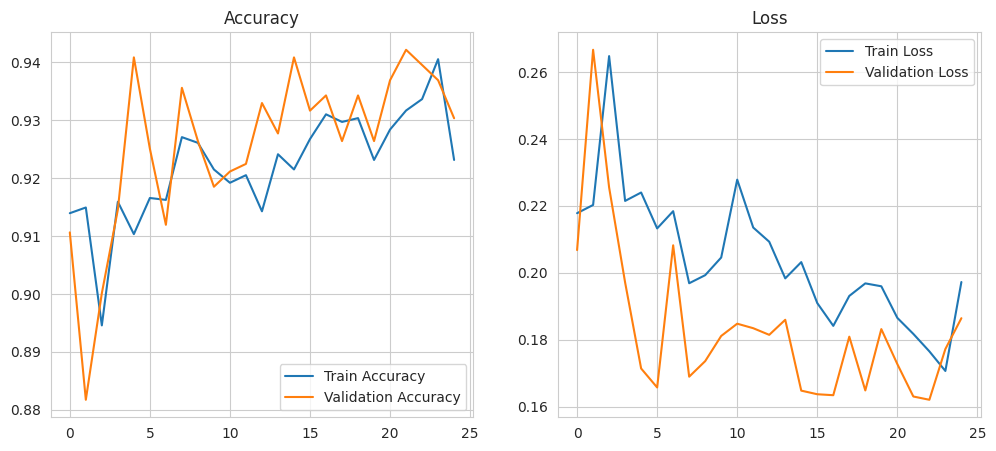

In [104]:

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


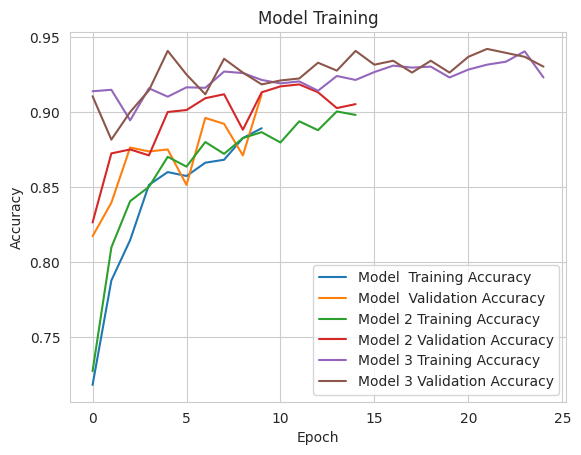

In [108]:
plt.plot(history.history['accuracy'], label='Model  Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Model  Validation Accuracy')
plt.plot(history2.history['accuracy'], label='Model 2 Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Model 2 Validation Accuracy')
plt.plot(history3.history['accuracy'], label='Model 3 Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Model 3 Validation Accuracy')
plt.title('Model Training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

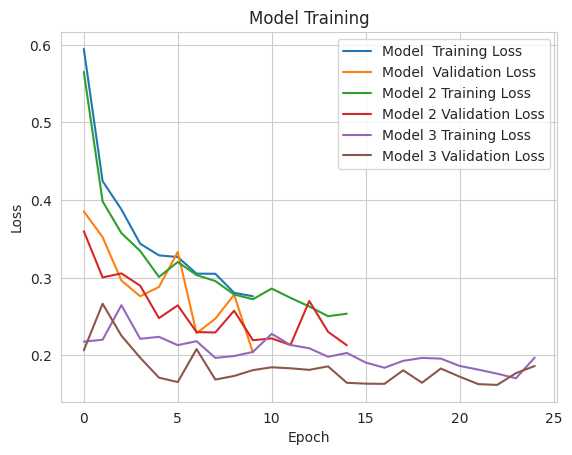

In [106]:
plt.plot(history.history['loss'], label='Model  Training Loss')
plt.plot(history.history['val_loss'], label='Model  Validation Loss')
plt.plot(history2.history['loss'], label='Model 2 Training Loss')
plt.plot(history2.history['val_loss'], label='Model 2 Validation Loss')
plt.plot(history3.history['loss'], label='Model 3 Training Loss')
plt.plot(history3.history['val_loss'], label='Model 3 Validation Loss')
plt.title('Model Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get class labels
class_labels = list(train_gen.class_indices.keys())

# Generate predictions
y_true = valid_gen.classes  
y_pred_prob = model3.predict(valid_gen)  
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert to class index


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


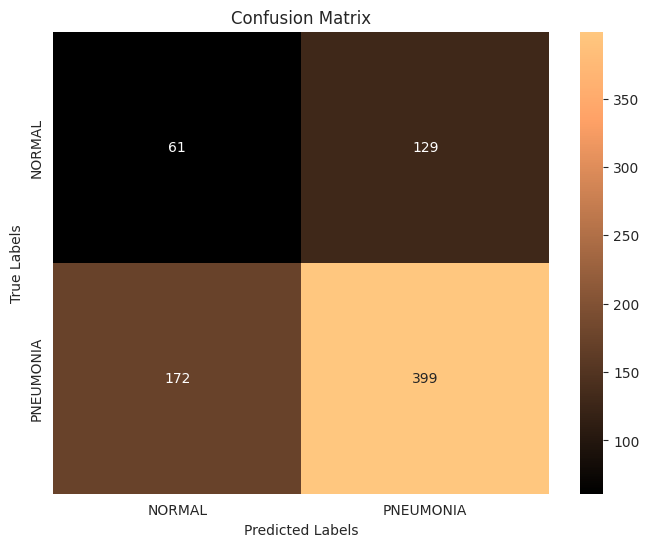

In [141]:

conf_matrix = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='copper', xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [111]:

report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.26      0.32      0.29       190
   PNEUMONIA       0.76      0.70      0.73       571

    accuracy                           0.60       761
   macro avg       0.51      0.51      0.51       761
weighted avg       0.63      0.60      0.62       761

